In [394]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from scipy.stats import norm

from IPython.core.display import display, HTML
from IPython.display import clear_output
    
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
!ls

Untitled.ipynb      owid-covid-data.csv


In [3]:
df = pd.read_csv('owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [91]:
df_russia = df[df.location == 'Russia']
df_russia = df_russia[df_russia.date >= '2020-03-03']
df_russia = df_russia.sort_values(by='date')
df_russia['new_cases'] = df_russia['new_cases'].replace(0., 1.)
df_russia['date'] = pd.to_datetime(df_russia['date'])

min_date = df_russia['date'].min()
df_russia['x'] = df_russia['date'].apply(lambda x: (x - min_date).days) 
df_russia_50 = df_russia.iloc[:50,:].copy()
df_russia_50.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,x
123955,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,0
123956,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,1
123957,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,2
123958,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,3
123959,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,4


<AxesSubplot:xlabel='date'>

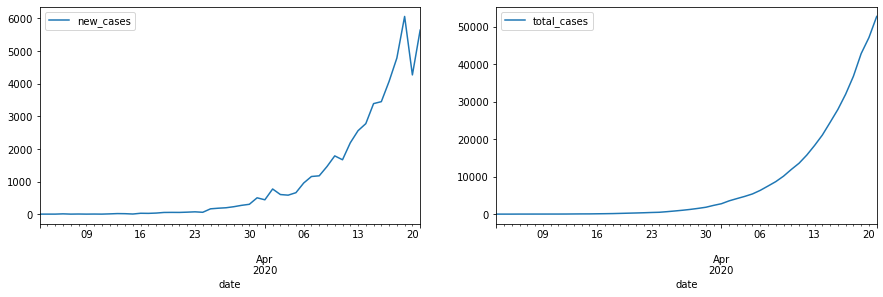

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

df_russia_50[['date', 'new_cases']].set_index('date').plot(ax = ax[0])
df_russia_50[['date', 'total_cases']].set_index('date').plot(ax = ax[1])

## Task 2a (may be exp)

<AxesSubplot:xlabel='date'>

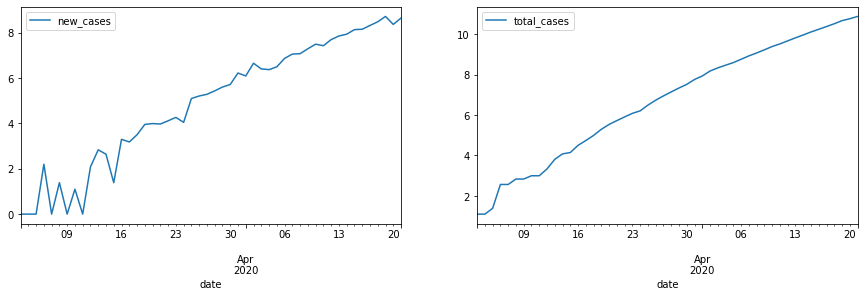

In [302]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

df_tmp = df_russia_50[['date', 'new_cases']].set_index('date')
df_tmp['new_cases'] = np.log(df_tmp['new_cases'])
df_tmp.plot(ax = ax[0])
df_tmp = df_russia_50[['date', 'total_cases']].set_index('date')
df_tmp['total_cases'] = np.log(df_tmp['total_cases'])
df_tmp.plot(ax = ax[1])

'sigma_noise = 0.34904220596356583'

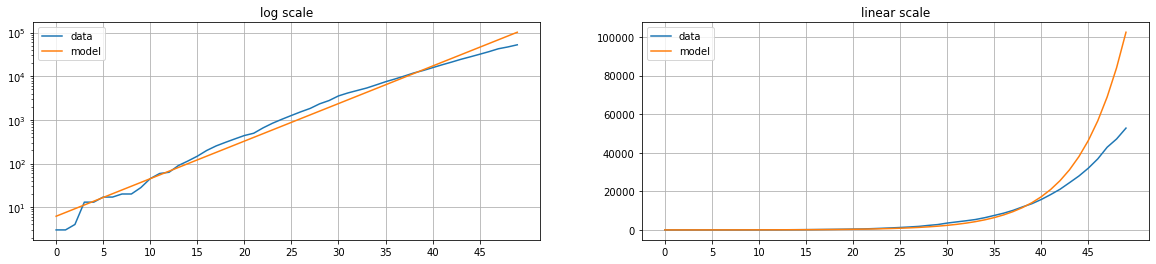

In [303]:
def create_exp_from_reg(a, b):
    def exp(x):
        return np.exp(a * x + b)
    
    return exp


min_date = df_russia_50['date'].min()
X = np.array(df_russia_50['x'])
y = np.log(np.array(df_russia_50['total_cases']))

reg = LinearRegression()

reg.fit(X[:, None], y)

fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax[0].plot(X, np.exp(y))
a = reg.coef_
b = reg.intercept_
f = create_exp_from_reg(a, b)
ax[0].plot(X, f(X))
ax[0].legend(['data', 'model'])
ax[0].set_yscale('log')
ax[0].set_title('log scale')
ax[0].grid(True)
ax[0].set_xticks(X[::5])

ax[1].plot(X, np.exp(y))
ax[1].plot(X, f(X))
ax[1].legend(['data', 'model'])
ax[1].set_title('linear scale')
ax[1].grid(True)
ax[1].set_xticks(X[::5])

sigma_noise = np.std(y - np.log(f(X)))
f'sigma_noise = {sigma_noise}'

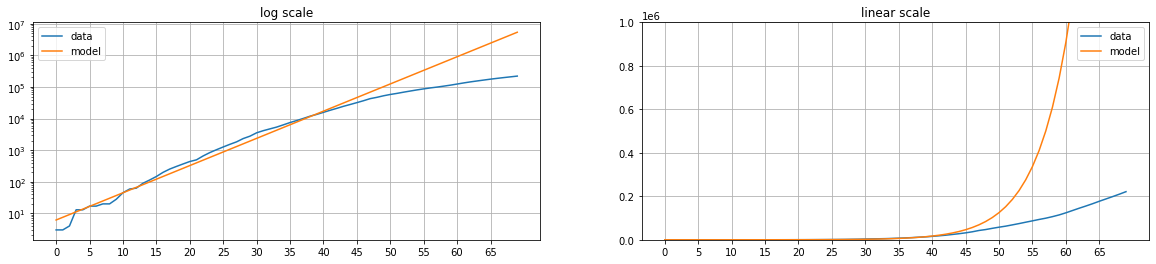

In [304]:
df_tmp = df_russia.iloc[:70,:].copy()

X_ = np.array(df_tmp['x'])
y_ = np.array(df_tmp['total_cases'])

fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax[0].plot(X_, y_)

a = reg.coef_
b = reg.intercept_
f = create_exp_from_reg(a, b)
ax[0].plot(X_, f(X_))
ax[0].legend(['data', 'model'])
ax[0].set_yscale('log')
ax[0].set_title('log scale')
ax[0].grid(True)
ax[0].set_xticks(X_[::5])

ax[1].plot(X_, y_)
ax[1].plot(X_, f(X_))
ax[1].legend(['data', 'model'])
ax[1].set_title('linear scale')
ax[1].grid(True)
ax[1].set_ylim((0, 1e6))
_ = ax[1].set_xticks(X_[::5])

## Task 2b

(250, 250)


<ipython-input-382-db11e0680abd>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


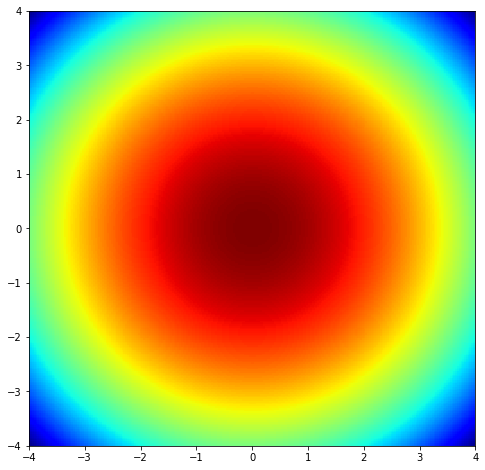

In [382]:
cur_mu, cur_sigma = np.array([0, 0]), 200 * MAX_X * np.array([[1, 0], [0, 1]], dtype = 'float')


X = np.linspace(-4, 4, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.show()

In [385]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.ones((x.shape[0], 2), dtype = 'float')
    x_matrix[:,1] = x
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(
        sigma_n, 
        np.matmul(
            np.linalg.inv(sigma), 
            np.transpose(mu)
        )[:, None] + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]).T) 
    )
    return mu_n[:,0], sigma_n

(250, 250)


<ipython-input-386-9e0e5f3304ce>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


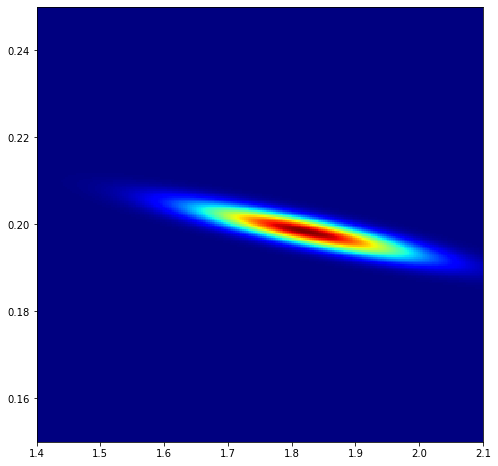

In [386]:
px = np.array(df_russia_50['x'], dtype = 'float')
py = np.log(np.array(df_russia_50['total_cases'], dtype = 'float'))

new_mu, new_sigma = bayesian_update(cur_mu, cur_sigma, px, py,sigma_noise)

X = np.linspace(1.4, 2.1, N)
Y = np.linspace(0.15, 0.25, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=new_mu, cov=new_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((1.4, 2.1))
ax.set_ylim((0.15, 0.25))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.show()

In [308]:
def myplot_sample_lines(mu, sigma, ax, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    xs = np.array([x for x in range(50)])
    for w in my_w:
        f = create_exp_from_reg(w[1], w[0])
        ax[0].plot(xs, f(xs), linewidth=.1, color="0.3")
        ax[1].plot(xs, np.log(f(xs)), linewidth=.1, color="0.3")

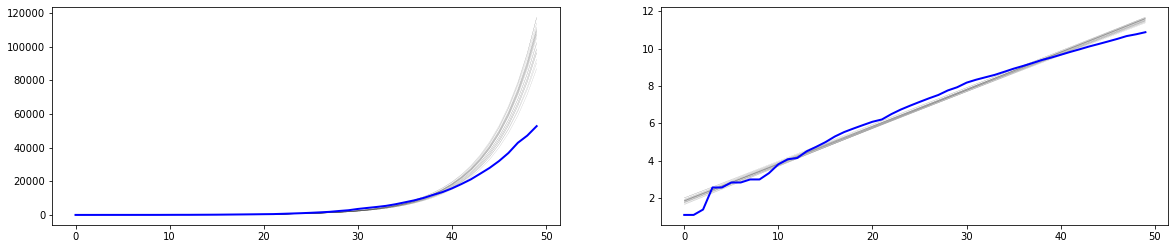

In [309]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))
myplot_sample_lines(new_mu, new_sigma, ax, 20)
ax[0].plot(np.array(df_russia_50['x']), np.array(df_russia_50['total_cases']), linewidth=2, color='b')
ax[1].plot(np.array(df_russia_50['x']), np.log(np.array(df_russia_50['total_cases'])), linewidth=2, color='b')

## 3b (may be sigmoid)

Не много слов:
Мы можем сделать обратное преобразование над целевой переменной, при дифференцировании у нас будет просто exp, но мы перейдем от total_cases к new_cases (как производная), далее мы можем брать логорифм, так как мы вначале, незная того, заменили 0 на 1 в new_cases, то у нас не будет ln(0). 

Получается наша целевая переменная ln(new_cases), а параметры модели это days, days^2 и свободный член

In [391]:
first_n = 100

cur_mu_3, cur_sigma_3 = np.array([0, 0, 0]), 200 * MAX_X * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype = 'float')

df_tmp = df_russia.iloc[:first_n,:].copy()
df_tmp['x_2'] = df_russia['x'] ** 2
X_3 = np.asarray(df_tmp[['x', 'x_2']])
y_3 = np.array(df_tmp['new_cases'])

In [389]:
reg = LinearRegression()

reg.fit(X_3, np.log(y_3))

sigma_noise = np.std(np.log(y_3) - (X_3 @ np.array([*reg.coef_])[:, None])[:,0] + reg.intercept_)
sigma_noise

0.41117727375309626

In [393]:
def new_bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.ones((x.shape[0], x.shape[1] + 1), dtype = 'float')
    x_matrix[:,1:] = x
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(
        sigma_n, 
        np.matmul(
            np.linalg.inv(sigma), 
            np.transpose(mu)
        )[:, None] + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]).T) 
    )
    return mu_n[:,0], sigma_n


new_mu, new_sigma = new_bayesian_update(cur_mu_3, cur_sigma_3, X_3, y_3, sigma_noise)

new_mu, new_sigma

(array([-2.51829924e+03,  1.88918893e+02, -5.79543365e-01]),
 array([[ 1.46229723e-02, -5.87833437e-04,  4.92322809e-06],
        [-5.87833437e-04,  3.18699081e-05, -3.01424021e-07],
        [ 4.92322809e-06, -3.01424021e-07,  3.04469334e-09]]))